# Get the data and make it suitable for input

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls gdrive/MyDrive/ML_Datasets/

UTK_dataset.zip


In [3]:
!unzip gdrive/MyDrive/ML_Datasets/UTK_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

# Data Label Extraction

In [4]:
import pandas as pd
import os

# Function to rename files in a directory
def rename_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg.chip.jpg"):
            # Create the new filename by replacing '.jpg.chip.jpg' with '.jpg'
            new_filename = filename.replace('.jpg.chip.jpg', '.jpg')

            # Construct the full file paths
            current_filepath = os.path.join(folder_path, filename)
            new_filepath = os.path.join(folder_path, new_filename)

            # Rename the file
            os.rename(current_filepath, new_filepath)
            #print(f"Renamed {filename} to {new_filename}")

# Function to extract information from image file names
def extract_info_from_filename(filename):
    # Split the filename by underscores
    parts = filename.split('_')
    # Extract relevant information
    age = int(parts[0])
    gender = int(parts[1])
    race = int(parts[2])
    return age, gender, race

def can_extract_info(filename):
    parts = filename.split('_')
    if (len(parts)<4):
        print(filename + " has missing values.")
        return False
    else:
        return True

# Function to get image file names in a folder
def get_image_info(folder_path):
    image_info = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Consider only JPG files
            if can_extract_info(filename):
                age, gender, race = extract_info_from_filename(filename)
                image_id = os.path.splitext(filename)[0]  # Remove file extension to get image ID
                image_info.append((image_id, age, gender, race))

    return image_info

# Create a DataFrame from image information
def create_dataframe(folder_path):
    image_info = get_image_info(folder_path)
    df = pd.DataFrame(image_info, columns=['Image_ID', 'Age', 'Gender', 'Race'])
    return df

In [ ]:
!ls

crop_part1  data  drive  gdrive  sample_data  UTKFace  utkface_aligned_cropped


In [5]:
folder_path = 'UTKFace'

rename_files(folder_path)

# Define the directory to save the DataFrame
output_directory = 'data'

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path
output_file_path = os.path.join(output_directory, 'UTKFace_labels.csv')

# Save the DataFrame to a CSV file in the new directory
image_dataframe = create_dataframe(folder_path)
image_dataframe.to_csv(output_file_path, index=False)

61_1_20170109150557335.jpg has missing values.
39_1_20170116174525125.jpg has missing values.
61_1_20170109142408075.jpg has missing values.


# Preprocessing

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import convert_to_tensor

In [7]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Path to your dataset folder
dataset_folder = 'UTKFace'

# Get a list of all image filenames in the dataset folder
all_images = os.listdir(dataset_folder)

# Split the dataset into train, validation, and test sets
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# Define the paths for train, validation, and test folders
train_folder = 'train'
val_folder = 'validation'
test_folder = 'test'

# Create folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Move images to their respective folders
for img in train_images:
    shutil.move(os.path.join(dataset_folder, img), os.path.join(train_folder, img))

for img in val_images:
    shutil.move(os.path.join(dataset_folder, img), os.path.join(val_folder, img))

for img in test_images:
    shutil.move(os.path.join(dataset_folder, img), os.path.join(test_folder, img))


In [8]:
# Image size
target_size = (100, 100)

# Create ImageDataGenerators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create custom data generators for training, validation, and testing
class CustomDataGenerator(Sequence):
    def __init__(self, folder, batch_size=32, target_size=(100, 100), datagen=None):
        self.folder = folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.datagen = datagen
        self.indexes = np.arange(len(os.listdir(folder)))

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batch_size))

    #IN HERE SOPHIE SPECIFIES IF WE TAKE AGE OR GENDER
    #I WANT BOTH
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size
        batch_indexes = self.indexes[start_idx:end_idx]

        batch_images = [os.listdir(self.folder)[i] for i in batch_indexes]
        batch_labels = [int(img.split('_')[0]) for img in batch_images]

        # Load and preprocess images
        batch_x = []
        for img_name in batch_images:
            img_path = os.path.join(self.folder, img_name)
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            batch_x.append(img_array)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_labels)

        if self.datagen:
            # Apply data augmentation
            batch_x = self.datagen.flow(batch_x, shuffle=False).next()

        return batch_x, batch_y

In [10]:
# Create instances of the custom data generators
train_generator = CustomDataGenerator(train_folder, batch_size=32, target_size=target_size, datagen=train_datagen)
val_generator = CustomDataGenerator(val_folder, batch_size=32, target_size=target_size, datagen=val_datagen)
test_generator = CustomDataGenerator(test_folder, batch_size=32, target_size=target_size, datagen=test_datagen)

Image shape: (200, 200, 3)
Image shape: (200, 200, 3)
Image shape: (200, 200, 3)
Image shape: (200, 200, 3)


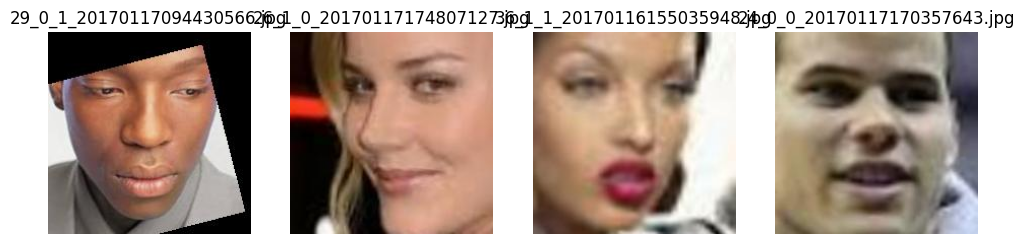

In [11]:
import matplotlib.pyplot as plt
import random

# Function to display images
def plot_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# Choose random samples from the train dataset
random_samples = random.sample(os.listdir(train_folder), 4)

# Load and display the selected images
selected_images = []
for img_name in random_samples:
    img_path = os.path.join(train_folder, img_name)
    img = plt.imread(img_path)
    selected_images.append(img)
    print(f"Image shape: {img.shape}") #show the shape of the image

# Display the images
plot_images(selected_images, random_samples)

In [12]:
#Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):
  #Setup the target directory (we'll view images from here)
  target_folder = target_dir

  #Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) #randomly sample one of the items in here
  print(random_image)

  #Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off")

  print(f"Image shape: {img.shape}") #show the shape of the image

  return img

['36_0_1_20170117135448300.jpg']
Image shape: (200, 200, 3)


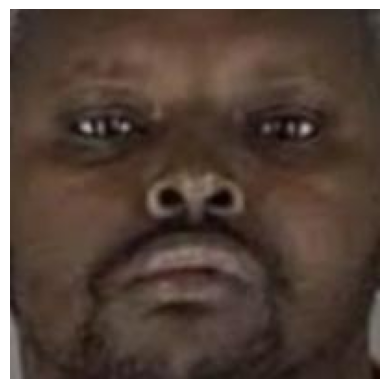

In [13]:
# View a random image from the training dataset
img = view_random_image(target_dir = test_folder)

In [14]:
# The images we've imported are actually giant arrays/tensors of different pixel values
import tensorflow as tf

#ternsors are inputs to our neural networks
tf.constant(img/255)

<tf.Tensor: shape=(200, 200, 3), dtype=float64, numpy=
array([[[0.34901961, 0.30980392, 0.30196078],
        [0.37254902, 0.33333333, 0.3254902 ],
        [0.39215686, 0.35294118, 0.34509804],
        ...,
        [0.22745098, 0.20784314, 0.19215686],
        [0.23921569, 0.21960784, 0.20392157],
        [0.25098039, 0.23137255, 0.21568627]],

       [[0.36470588, 0.3254902 , 0.31764706],
        [0.37254902, 0.33333333, 0.3254902 ],
        [0.36862745, 0.32941176, 0.32156863],
        ...,
        [0.23529412, 0.21568627, 0.2       ],
        [0.24705882, 0.22745098, 0.21176471],
        [0.2627451 , 0.24313725, 0.22745098]],

       [[0.37254902, 0.33333333, 0.3254902 ],
        [0.36862745, 0.32941176, 0.32156863],
        [0.34117647, 0.30196078, 0.29411765],
        ...,
        [0.25098039, 0.23137255, 0.21568627],
        [0.26666667, 0.24705882, 0.23137255],
        [0.28235294, 0.2627451 , 0.24705882]],

       ...,

       [[0.48235294, 0.4627451 , 0.45098039],
        [0.47

In [15]:
#view the image shape
img.shape #returns width, height, colour channels

(200, 200, 3)

Image shape: (100, 100, 3)
Image shape: (100, 100, 3)
Image shape: (100, 100, 3)
Image shape: (100, 100, 3)


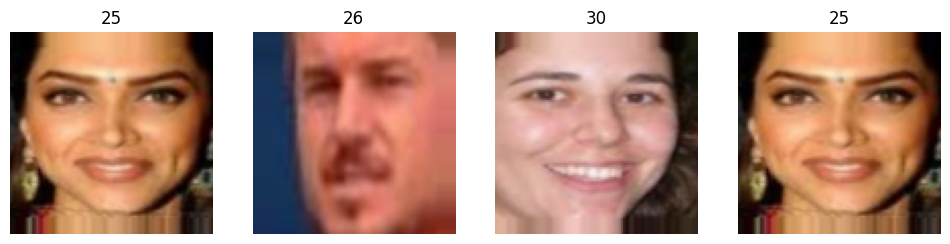

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def plot_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        print(f"Image shape: {img.shape}") #show the shape of the image
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# Choose random samples from the train generator
batch_x, batch_y = train_generator[np.random.choice(len(train_generator), size=1)[0]]
random_indices = np.random.choice(len(batch_x), 4)

# Select and display the images from the batch
selected_images = [batch_x[i] for i in random_indices]
selected_labels = [batch_y[i] for i in random_indices]

# Display the images
plot_images(selected_images, selected_labels)


In [17]:
# Choose a random sample from the train generator
batch_x, batch_y = train_generator[np.random.choice(len(train_generator), size=1)[0]]
random_index = np.random.choice(len(batch_x), 1)[0]

# Select and display the image from the batch
selected_image = batch_x[random_index]
selected_label = batch_y[random_index]

#ternsors are inputs to our neural networks
tf.constant(selected_image)


<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.34907028, 0.32946244, 0.4196585 ],
        [0.34073234, 0.3211245 , 0.41132057],
        [0.33896858, 0.31936073, 0.4095568 ],
        ...,
        [0.03358041, 0.02965884, 0.06103139],
        [0.03062582, 0.02670425, 0.05478526],
        [0.02704916, 0.02312759, 0.046657  ]],

       [[0.3431809 , 0.32239476, 0.41612568],
        [0.34100705, 0.32022095, 0.41395187],
        [0.3441085 , 0.32332236, 0.4170533 ],
        ...,
        [0.04208092, 0.03815936, 0.0695319 ],
        [0.04111602, 0.03719445, 0.06628017],
        [0.03472957, 0.030808  , 0.05574684]],

       [[0.3482139 , 0.32618392, 0.42589557],
        [0.35274968, 0.33071968, 0.43043134],
        [0.35619304, 0.33416304, 0.4338747 ],
        ...,
        [0.05056142, 0.04589015, 0.07951182],
        [0.05160623, 0.04693495, 0.08055662],
        [0.04274918, 0.03807791, 0.06916813]],

       ...,

       [[0.30172354, 0.2821157 , 0.3056451 ],
        [0.25

In [18]:
tf.print(selected_label)

26


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import backend as K

# Clear Keras session
K.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = 3,
                           activation = "relu",
                           input_shape = (100, 100, 3)),
    tf.keras.layers.Conv2D(64, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = "valid"),
    tf.keras.layers.Conv2D(64, 3, activation = "relu"),
    tf.keras.layers.Conv2D(64, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "linear")
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                   

In [24]:
# Assuming train_generator and val_generator are already defined
epochs = 10
batch_size = 32

# Train the model with validation
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    batch_size=batch_size
)


Epoch 1/10
534/534 [==============================] - 249s 452ms/step - loss: 366.1015 - accuracy: 0.0474 - val_loss: 276.4512 - val_accuracy: 0.0422
Epoch 2/10
534/534 [==============================] - 234s 438ms/step - loss: 216.9834 - accuracy: 0.0476 - val_loss: 158.1296 - val_accuracy: 0.0422
Epoch 3/10
534/534 [==============================] - 234s 439ms/step - loss: 165.7324 - accuracy: 0.0469 - val_loss: 124.1519 - val_accuracy: 0.0406
Epoch 4/10
534/534 [==============================] - 240s 450ms/step - loss: 138.1628 - accuracy: 0.0455 - val_loss: 113.6181 - val_accuracy: 0.0358
Epoch 5/10
534/534 [==============================] - 231s 432ms/step - loss: 125.2042 - accuracy: 0.0435 - val_loss: 127.0292 - val_accuracy: 0.0385
Epoch 6/10
534/534 [==============================] - 226s 423ms/step - loss: 119.2538 - accuracy: 0.0427 - val_loss: 107.4601 - val_accuracy: 0.0311
Epoch 7/10
534/534 [==============================] - 225s 421ms/step - loss: 113.7647 - accuracy: 0

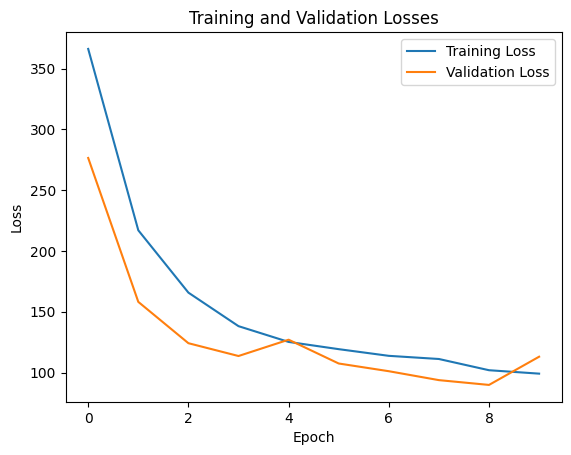

In [25]:
# Plot training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Assuming you have a test generator named test_generator
all_labels = []

for data in test_generator:
    _, ages = data
    all_labels.extend(ages)

# Convert the list to a NumPy array
all_labels = np.array(all_labels)

# Print the shape of the extracted labels
print(f"All Labels Shape: {all_labels.shape}")

All Labels Shape: (4742,)


In [38]:
# Assuming you have a test generator (test_generator) and the model is already trained
# Evaluate the model on the test data
results = model.evaluate(test_generator, batch_size=batch_size)

# Get predictions on the test data
predictions = model.predict(test_generator, batch_size=batch_size)

# Extract true ages from the test data
true_ages = all_labels

# Calculate the absolute difference between predicted and true ages
absolute_errors = np.abs(predictions.squeeze() - true_ages)

# Define the acceptable error range (e.g., ±5)
acceptable_error_range = 10

# Count the number of correct predictions within the acceptable error range
correct_predictions = np.sum(absolute_errors <= acceptable_error_range)

# Calculate the percentage of correct predictions
percentage_correct = (correct_predictions / len(true_ages)) * 100

print(f"Percentage of correct predictions within ±{acceptable_error_range} years: {percentage_correct:.2f}%")

149/149 [==============================] - 16s 110ms/step
Percentage of correct predictions within ±10 years: 68.26%
